# The effect of a Universal Child Benefit - González (2013) Revisited

### A Project by Antonia Entorf & Marc Lipfert

## Overview

This notebook replicates the main results presented in the following article:   

González, L. (2013): [The Effect of a Universal Child Benefit on Conceptions, Abortions, and Early Maternal Labor Supply](https://www.aeaweb.org/articles?id=10.1257/pol.5.3.160). American Economic Journal: Economic Policy 5(3): 160–188.

In that paper, the author investigates the short-term effects of a universal child benefit on fertility, household expenditure patterns and maternal labor supply. In particular, she is able to exploit the unanticipated introduction of such a policy that took place in Spain in 2007 by utilizing a sharp Regression Discontinuity Design.

The author obtains evidence suggesting a significant increase in fertility, partly driven by a reduction in the number of abortions. Furthermore, she finds no effect on overall household expenditures, a significantly negative effect on mothers’ labor supply the year after giving birth and significantly lower use of formal day care.

Apart from replicating key findings presented by González, our aim is to enrich her analysis with respect to two major aspects. First, we will conduct a critical assessment of the author's empircal work. For this, we will examine whether accounting for autocorrelation is necessary in the given context and show revised estimates based on a more precise computation of the month of conception. Secondly, we will perform further analyses. On the one hand, since the benefit was suspended in the aftermath of the financial crisis, we will exploit this fact and apply the identical research design to the abolishment of the policy in order to study the effect on conceptions. On the other hand, we will investigate the general reliability of the research design by executing two Placebo tests and a simulation study.

## Table of Contents

[1.) Description of the Policy and of its (potential) Effects](#policy) 

[2.) Empirical Strategy](#empirical_strategy)

[3.) Replication of Main Results](#replication)

$\qquad$ [3.1) Fertility](#fertility)
   
$\qquad$ [3.2) Household Expenditure and Labor Supply](#hbs_lfs)

[4.) Critical Assesment of the Author's Empirical Work](#critique)

$\qquad$ [4.1) Autocorrelation](#autocorr)
   
$\qquad$ [4.2) Computing Month of Conception More Precisely](#mc_revised)
   
$\qquad$ [4.3) Global vs. Local Polynomial Time Trend](#global_poly)

[5.) Further Analyses](#further_analyses)

$\qquad$ [5.1) Heterogenous Treatment Effects](#hetero_treat)
   
$\qquad$ [5.2) Abolishment of the Policy](#abolishment)
   
$\qquad$ [5.3) General Reliability (Placebo Test & Simulation)](#general_reliability)
   

[6.) Conclusion](#conclusion)

[References](#references)

[Appendix](#appendix)

<a id='policy'></a>
## 1.) Description of the Policy and of its (potential) Effects 

On July 3, 2007, the Spanish government announced the introduction of a universal child benefit. Mothers giving birth from July 1, 2007, onwards were eligible to receive a one-time cash payment of 2,500€. The only requirement was being a legal resident of Spain for at least two years prior to the date of birth. Official reports by the Spanish tax authorities suggest a take-up rate of at least 95% (González 2013: p. 163) which implies that the policy was known and relevant.

González (2013) analyzes the effect of this child benefit on the monthly number of conceptions and abortions as well as on household expenditures, maternal labor supply and the use of day care. She uses a sharp regression discontinuity design (RDD) for her analysis, where the running variable is time and the treatment variable is equal to 1 from July 2007 onwards and 0 beforehand.

An aspect that could subsequently cause problems for the estimation of the effect of the policy is self-selection into treatment. In this particular setting one could imagine that women try to postpone birth in order to give birth after the cutoff date and not before. This scenario seems especially plausible for low income families who are in greater need of the cash payment. Therefore, mothers giving birth right before and right after the cutoff could differ in personal characteristics, such as income and education. This could lead to a bias in the estimated treatment effect if low income families react differently to receiving treatment compared to high income families and, additionally, often does not permit to control for these personal characteristics.

However, self-selection into treatment was not possible in the given setting because the introduction of the policy happened unexpectedly and the announcement was even two days after the actual cutoff date. These two aspects rule out the possibility to postpone birth in order to receive the benefit.

#### Effects on Fertility

<img src="causal-graphs/causal-graph-fertility.png" width="600" />

Following Pearl (2000), we use graphical models to shed light on the (assumed) causal relationships between the involved variables. The causal graph above represents two regression analyses conducted in the article. First, González is interested in the effect of the introduction of the child benefit on the number of conceptions per month ($Y_1$) and, secondly, on the number of abortions per month ($Y_2$). Thus, the binary treatment variable, $D$, is the introduction of the child benefit and $Y_1$ as well as $Y_2$ are the dependent variables. In this graph, the treatment should be interpreted as having the possibility to get the benefit and not as already having received the benefit.

The running variable, time $T$, determines assignment to treatment and, furthermore, influences conceptions and abortions through seasonality effects. The treatment variable is supposed to influence conceptions and abortions, which both determine the number of births. Furthermore, the number of abortions is influenced by the number of conceptions.

Drawing again on Pearl (2000), we consider back-door paths from the treatment variable $D$ to the dependent variables. As can be inferred from the graph, there are the paths $D \leftarrow T \rightarrow Y_1$ and $D \leftarrow T \rightarrow Y_2$. The effect of $D$ on $Y_1$ and $Y_2$ is confounded by $T$. Therefore, it is necessary to condition on $T$ to block the back-door path and, thereby, to obtain an unbiased estimate of the treatment effect. This is done by the author by specifying a time trend which is then employed in her regression analysis.

Considering the identification of the causal effect of $D$ on $Y_2$, one sees that the total treatment effect is also influenced by the effect of $D$ on $Y_1$. This appears to be plausible as changes in the number of conceptions are likely to affect the numbber of abortions. Thus, the estimated effect of $D$ on $Y_2$ usually cannot be interpreted as partial (direct) effect but as total iimpact of the policy. The only exception would be the change in $Y_2$ observed shortly after the introduction of the policy since the channel through $Y_1$ needs some time to make an impact.

It is important to note that we actually do not observe the number of *conceptions* per month but only the monthly number of *births*. González' idea was then to calculate the month of conception based on the month of birth by subtracting the approximate number of months a woman was pregnant. However, birth is a collider variable mutually depending on conceptions and abortions. Thus, when calculating conceptions while ignoring abortions our results might not be accurate. To illustrate this, imagine that the treatment does not at all affect the number of conceptions. However, at the same time many treated women decide against an abortion while their untreated counterfactual would have decided for an abortion. Thus, the treatment causes a reduction in the number of abortions which, clearly, leads to an increase in the number of births. If we then calculate conceptions based on births it would look like an increase in the number of conceptions, although this number was unchanged. Therefore, one must bear in mind that a change in the conceptions variable can be partly driven by a change in the abortions variable. The author also mentions this dependence of the conceptions variable on abortions and communicates her estimated effect as the impact on fertility.

#### Effects on Economic Variables

<img src="causal-graphs/causal-graph-economic-variables.png" width="600" />

The second causal graph represents the remaining three regression analyses of the article. Now, the dependent variables are household expenditures, maternal labor supply and day care use.

There is a slight difference in the interpretation of the treatment variable, $D$, compared to the first causal graph. This time, $D$ should be interpreted as already having received the cash payment, because González compares families *having* children shortly before and after the cut-off date.

Again, $T$ determines treatment status, $D$, and we are interested in the effects of $D$ on different outcome variables. At the threshold, treatment should be assigned “as-if” it happened randomly and differences between treatment and control group could only occur by chance since influencing the treatment status was not possible. Thus, we do not have any back-door path that needs to be blocked.

The treatment effect on household expenditures ($Y_3$) seems to be identified given our assumed causal graph. Personal characteristics have an effect on $Y_3$, but they do not have an influence on $D$ and, therefore, they do not bias the estimated treatment effect. Still, controlling for them increases the precision of the obtained estimate. Further, it might be fruitful to investigate heterogeneous treatment effects of the cash payment on expenditures for rich and poor families, because one can plausibly expect them to be different. This aspect will be taken up later on.

Considering the causal effect on $Y_4$ and $Y_5$ requires a careful interpretation. The author does not mention any dependence between these two variables, but we argue that maternal labor supply and day care use influence each other. A mother who is not working may not need a day care for her child, and a mother who does not find a day care may not be able to work. Consequently, we have reverse causality between $Y_4$ and $Y_5$. In order to identify the effect, González does not condition on day care use in the regression with labor supply as dependent variable and vice versa. Thus, the estimated treatment effects should be interpreted as total effects and not as partial (direct) effects.

<a id='empirical_strategy'></a>
## 2.) Empirical Strategy

To illustrate the empirical strategy and its potential pitfalls, we make use of the potential outcome framework first proposed by Rubin (1974). Notation is borrowed from the textbooks by Morgan and Winship (2015) as well as Frölich and Sperlich (2019).

The research question by González (2013) can be condensed as follows: she aims at quantifying the impact of the introduction of a universal child benefit on a range of outcome variables. Her study therefore constitutes a classical policy evaluation, i.e. an ex-post investigation in which the researcher seeks to obtain empirical evidence on the causal effect of a policy measure. The challenge, however, is that the outcome variables are typically affected by many other factors - otherwise one could simply conduct a before-after comparison. Therefore, the causal effect has to be disentangled from the influence of those confounding factors.

Let $Y^d$ denote the potential outcome for treatment status $D = d$. Thus, $Y^1$ refers to the potential outcome with exposure to treatment and $Y^0$ to the potential outcome without treatment. The difference between them, $Y^1 - Y^0$, gives the causal eﬀect of the intervention. Naturally, both cannot be observed at the same time since treatment status is either $D = 1$ or $D = 0$.  The observed outcome $Y$ is given by: <a id='eq1'></a>

\begin{align*}
\text{(1)} \qquad Y = (1 - D) \cdot Y^0 + D \cdot Y^1   \text{ with } D \in \{0,1\}.
\end{align*}

In the given setting, the treatment status is determined by the variable $T$ ("running variable"), which is time in the given context: only mothers giving birth after a specified cut-off date $t_0$, i.e. July 1 2007, were eligible to claim the benefit. González (2013) provides several reasons why the treatment status can be viewed as being deterministically dependent on the running variable time, i.e. practically, all eligible mothers actually received the benefit. Importantly, administrative barriers were very low and merely entailed completing a one-page form. In 2008, the Spanish tax authorities reported paying out 491,557 child benefits which corresponds to 95% of the total number of births in that year (including ineligible mothers, i.e. those not having resided legally in Spain for at least two years before giving birth). Thus, treatment assignment can be formalized as follows: <a id='eq2'></a>

\begin{align*}
\text{(2)} \qquad  D = \boldsymbol{1} \{T \geq t_{0} \}.
\end{align*}

Taken together, such a setup lends itself to a sharp Regression Discontinuity Design (RDD). This identiﬁcation strategy, first introduced and applied by Thistlethwaite and Campbell (1960), exploits the discontinuous change in $D$ that occurs when the running variable $T$ reaches the known threshold value $t_0$. Then, under certain conditions, changes in the observed outcome $Y$ at the cut-oﬀ value $t_0$ can be ascribed to the alteration of the treatment status. Note, however, that this only allows causal inference at or around the threshold value, that is, a Local Average Treatment Effect (LATE) is retrieved. The evidence obtained regarding those local behavior changes can ususally not be generalised.

A Regression Discontinuity Design is typically applied to cross-sectional data. Generally, denoting the treatment variable with $Z$ and the threshold value with $z_0$, a RDD allows to infer the causal effect of treatment without imposing extensive paramentric assumptions by simply comparing actual outcomes just below and right above the threshold $z_0$ - under the condition that there are many observations close to the cut-off value. In an ideal cross-sectional setting, clean identification is achieved even without conditioning on control variables. Hahn et. al. (2001) formalize this approach which, in more general notation, reads as follows: <a id='eq3'></a>

\begin{align*}
\text{(3)} \qquad E[Y^{1}-Y^{0} | Z=z_{0}] = \lim_{\varepsilon \to 0} E[Y|Z=z_{0}+\varepsilon]-\lim_{\varepsilon \to 0} E[Y|Z=z_{0}-\varepsilon].
\end{align*}

The only assumption necessary, in the cross-sectional case as well as when dealing with time series data, is that potential outcomes evolve smoothly around the cut-off value: if $Y^1$ or $Y^0$ were exhibiting a jump at the threshold anyway, it would not be possible to extract the causal impact of treatment which would render the whole method inapplicable. Following Lee and Lemieux (2010), this assumption is commonly violated when individuals can manipulate their value of the running variable $Z$ and intend to sort into or out of treatment. Drawing again on Hahn et. al. (2001) and using the notation that is more specific to the given context, the crucial identifying assumption $(A)$ can be stated as follows: <a id='A'></a>

\begin{align*}
\text{(A)} \qquad E[Y^{d}|T=t] \text{ continuous in } t \text{ around } t_{0} \text{ for } d \in \{0,1\}.
\end{align*}

Coming back to the actual setting, there are upsides and downsides. First, time as running variable and the particular features of time series data pose certain problematic issues. Secondly, sorting around the threshold can be ruled out in the matter at hand, but still smoothness of the potential outcomes cannot be claimed without further ado. Both aspects shall be discussed in the following.

With regard to the fist point, it would be more precise to refer to the employed research design as Regression Discontinuity in Time (RDiT). Its corresponding pitfalls and the conceptual differences compared to the classical cross-sectional RDD are emphasised by Hausman and Rapson (2018).  For a start, once pure time series data is considered, the only way to reach an appropriate degree of statistical power is to expand the time frame. While in cross-sectional applications precision can, in principle, be raised by increasing the number of observations within a given bandwidth around the threshold, pure time series data has, by definition, only one observation per discrete point in time. This is for example the case when González (2013) analyzes the effect on conceptions - there she only has monthly sums available. However, drawing on observations further away from the cutoff-date constitutes a major departure from the cross-sectional approach described above. In particular, the method becomes more vulnerable to bias from unobserved confouding variables.

Further, an inherent issue when dealing with time series data is that the error terms are likely to exhibit serial correlation. There are different solution approaches to address this problem, one of them would be the use of clustered standard errors. Alternatively, heteroscedasticity and autocorrelation robust estimation techniques can be employed, such as the one proposed by Newey and West (1987). Since González (2013) does not explicitly refer to this problem in her article, we will take up this issue later on. 

Regarding the second point, the setup in Spain is particularly suitable for applying a RDiT since anticipation effects and corresponding sorting around the threshold are ruled out. According to González (2013), the policy was unexpectedly announced on July 03, 2007, and the eligibility cut-off date was subsequently moved to July 01, 2007. Therefore, sorting into treatment is rendered practically impossible. 

Still, concerns that the key identification assumption [(A)](#A), i.e. smoothness of potential outcomes around the threshold, is violated are not overcome just by ruling out sorting around the threshold. The focus is therefore on other factors discontinuously affecting potential outcomes during the period under consideration. González (2013) argues that "no  other  policy  changes  in  2007  or  thereafter  applied  differentially  to  children  born  before  and  after July 1, 2007" - a claim that we can neither verify nor falsify. 

Apart from discontinuous policy changes, major concerns relate to seasonality effects and the overall time trend. While in the cleanest cross-sectional RDD one can retrieve an unbiased estimate of the causal effect without conditioning on control variables, those are needed in a RDiT setting to prevent bias. Clearly, controlling for the number of days of the month when considering monthly conceptions or abortions appears to be reasonable. Furthermore, it has to be accounted for the overall time trend as well as for monthly patterns if possible. 

Turing towards the regression equations that are actually estimated by the author, first consider the specification without calender month dummies: <a id='eq4'></a>

\begin{align*}
\text{(4)} \qquad Y_m = \alpha + \theta \cdot m + \delta (m \cdot D) + \beta \cdot D + \lambda \cdot X_m + \epsilon_m.
\end{align*}

This is applied to (the natural logarithm of) the number of conceptions (and subsequently also to the number of arbortions) in month $m$, in form of the dependent variable $Y_m$. The treatment effect is given by $\beta$ which is the coefficient of the indicator variable $D$ taking value 1 beginning in July 2007, the month when the policy was adopted. $X_m$ denotes the number of calender days of the respective month. As can be seen from the equation, the running variable time, in form of month $m$, is included as regressor such that a time trend is estimated. The trend is allowed to differ pre/post treatment, which is captured by the interaction term $(m \cdot D)$. Note that in specifications with longer time frames, the author employs higher order polynomial time trends, while in the shortest specification (3 months pre/post-treatment) no time trend is included as regressor.

Longer time frames allow to control even more precisely for seasonal patterns because then calender month fixed effects can be estimated by adding respective dummy variables to the regression equation. That is why the author also applies the following regression equation to the same two dependet variables conceptions and abortions: <a id='eq5'></a>

\begin{align*}
\text{(5)} \qquad Y_m = \alpha + \theta \cdot m + \delta (m \cdot D) + \beta \cdot D + \lambda \cdot X_m + \sum_{c=2}^{12} \mu_c \cdot month_m + \epsilon_m.
\end{align*}

The author refers to this specification as a Difference-in-Difference (DiD) approach. However, we doubt that this term is approriate in this context. Therefore, we will refer to it as a monthly fixed effect (MFE) specification in the following

Lastly, González (2013) also has cross-sectional survey data available allowing her to apply the research design with respect to the labor supply decision of the mother as well as to different kinds of household expenditures and the use of day care as dependent variables. Therefore, she estimates the following regression equation: <a id='eq6'></a>

\begin{align*}
\text{(6)} \qquad Y_{im} = \alpha + \theta \cdot m + \delta (m \cdot D) + \beta \cdot D + \Pi \cdot \mathbf{X}^T_{im} + \epsilon_{im}.
\end{align*}

This specification is quite similar to equation [(4)](#eq4) but now a subscript $i$ denoting the individual household is added such that, for example, the row vector $\mathbf{X}_{im}$ comprises control variables like educational attainment of mother and father for household $i$ with their child being born in month $m$.

<a id='replication'></a>
## 3.) Replication of Main Results

<a id='fertility'></a>
### 3.1) Fertility
Before we can start with the data analysis we need to prepare the data sets. Therefore we translate the author's Stata code into python code. There are three different do-files using different datasets.

In the following I will give a brief overview over the translation of the "dofile_fertility_20110196.do" which can be found [(here)](https://www.aeaweb.org/articles?id=10.1257/pol.5.3.160) or in our data folder.

In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import matplotlib.pyplot as plt
import math as math
import scipy.stats as ss

from auxiliary.auxiliary_m import *
from auxiliary.auxiliary_a import *
from auxiliary.mc_more_precisely import *
from auxiliary.plots import *
from auxiliary.simulation_study import *

#### Conceptions:

The raw data is shown here:

*Variables* <br>
mesp: Month of birth <br>
year: Year of birth <br>
prem: Prematurity indicator (1 if baby is not premature, 2 if it is) <br>
semanas: Number of weeks of gestation at birth

In [2]:
pd.read_stata('data/data_births_20110196.dta').head()

,mesp,year,prem,semanas
0,3.0,2000.0,1,0.0
1,1.0,2000.0,2,36.0
2,3.0,2000.0,1,37.0
3,3.0,2000.0,1,39.0
4,12.0,2000.0,1,0.0


In [3]:
pd.read_stata('data/data_births_20110196.dta').describe().round(2)

,mesp,year,prem,semanas
count,4984066.00,4984066.00,4984066.00,4706361.00
mean,6.57,2041.50,1.07,34.93
std,3.44,35.83,0.26,11.71
min,1.00,2000.00,1.00,0.00
25%,4.00,2003.00,1.00,38.00
50%,7.00,2005.00,1.00,39.00
75%,10.00,2008.00,1.00,40.00
max,12.00,2010.00,2.00,46.00


The author creates a month of birth variable based on the month of the policy intervention in July 2007. The month of intervention is set equal to zero, the next month = 1, the previos month = -1, and so on.

In [4]:
dfb = gen_var_m()
dfb['m'].describe().round(2)

count    4984066.00
mean         -21.56
std           37.63
min          -90.00
25%          -53.00
50%          -20.00
75%           11.00
max           41.00
Name: m, dtype: float64

For our analysis we are not interested in the month of birth but in the month of *conception*. Therefore we subtract for examaple 9 months from the month of birth to get the month of conception. LG uses information about how many weeks the woman was pregnant (variable "semanas").

In [5]:
dfb = gen_var_mc()
dfb[['semanas', 'm', 'mc']].head()

,semanas,m,mc
0,0.0,-88.0,-97.0
1,36.0,-90.0,-98.0
2,37.0,-88.0,-96.0
3,39.0,-88.0,-97.0
4,0.0,-79.0,-88.0


Now, I the data is grouped by mc and the number of observations per month is counted. The resulting dataframe looks the following way:

In [6]:
dfb = group_data()
dfb.head()

,mc,n
0,-100.0,6
1,-99.0,24690
2,-98.0,30595
3,-97.0,32547
4,-96.0,32352


In the following some additional variables are generated. The author made some mistakes in generating two variables! The first one is a variable indicating the calendar month of conception ("month"), where she assigned the wrong calendar month to some observations. The second variable which has mistakes is a variable indicating how many days a particular month had ("days"). Thereby, LG did not take all leap years into account but only adjusted feburary in 2008 and missed feburary 2000 and 2004.

Other variables generated are: <br>
july = july indicator <br>
post = indicator for treatment group (post-policy conception), i.e. after June 2007 <br>
mc2, mc3 = quadratic and cubic mc <br>
ln = natural log of number of conceptions per month "n" <br>
month dummies <br>

In [7]:
dfb = complete_processing_conceptions_data()
dfb.head()

,mc,n,month,july,days,post,mc2,mc3,ln,jan,...,mar,apr,mai,jun,jul,aug,sep,oct,nov,dec
0,-100.0,6,3,0,31,0,10000.0,-1000000.0,1.791759,0,...,1,0,0,0,0,0,0,0,0,0
1,-99.0,24690,4,0,30,0,9801.0,-970299.0,10.114154,0,...,0,1,0,0,0,0,0,0,0,0
2,-98.0,30595,5,0,31,0,9604.0,-941192.0,10.328592,0,...,0,0,1,0,0,0,0,0,0,0
3,-97.0,32547,6,0,30,0,9409.0,-912673.0,10.390440,0,...,0,0,0,1,0,0,0,0,0,0
4,-96.0,32352,7,1,31,0,9216.0,-884736.0,10.384431,0,...,0,0,0,0,1,0,0,0,0,0


The following is part of the paper's Table 1 - Descriptive Statistics (p.167). The numbers we calculated are the same as the numbers in the paper.

In [8]:
print('Table 1 - Descriptive Statistics - Conceptions')
print(dfb.loc[(dfb['mc']>-91) & (dfb['mc']<30), ['n','post','mc']].describe().round(2))

Table 1 - Descriptive Statistics - Conceptions
              n    post      mc
count    120.00  120.00  120.00
mean   38020.64    0.25  -30.50
std     3167.55    0.43   34.79
min    30138.00    0.00  -90.00
25%    35775.25    0.00  -60.25
50%    38505.00    0.00  -30.50
75%    40305.75    0.25   -0.75
max    44375.00    1.00   29.00


### Plotting monthly conceptions

In [9]:
# generating year variable

dfb['year'] = np.nan

x = 0
while x < 12:
    dfb.loc[dfb['mc'] < 42 -(x*12), 'year'] = (2010 - x)
    x += 1

dfb.sort_values(by=['mc'], inplace=True)
dfb[['year','month','n']].head()

,year,month,n
0,1999.0,3,6
1,1999.0,4,24690
2,1999.0,5,30595
3,1999.0,6,32547
4,1999.0,7,32352


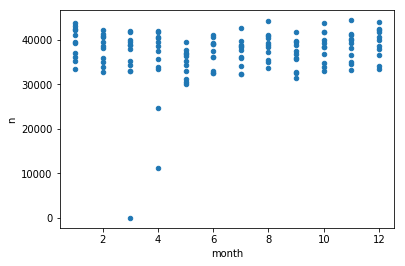

In [10]:
dfb.plot(x='month',y='n',kind="scatter")

In [11]:
# 3 outliers:
dfb.loc[dfb['n']<28000,['year','month','mc','n']]

,year,month,mc,n
0,1999.0,3,-100.0,6
1,1999.0,4,-99.0,24690
133,2010.0,4,33.0,11322


Think about outliers again....

In [12]:
# collecting mean values per month

month = {'month':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}
df_mean = pd.DataFrame(data=month)

df_mean['mean'] = np.nan

x=1
while x < 13:
    df_mean.loc[df_mean['month'] == x, 'mean'] = dfb.loc[(dfb['month']==x) & (dfb['year']>=2000) & \
                                                         (dfb['year']<=2009),'n'].mean()
    x += 1

df_mean

,month,mean
0,1,39091.7
1,2,37724.9
2,3,37263.4
3,4,38290.8
4,5,35146.9
5,6,37447.8
6,7,37429.5
7,8,39047.9
8,9,37088.8
9,10,38873.9


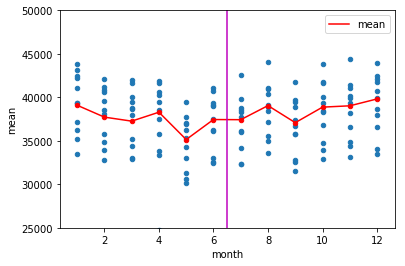

In [13]:
# Plotting scatter with mean

ax=dfb.plot(x='month',y='n',kind="scatter",ylim=(25000,50000))
ax1=df_mean.plot(x='month',y='mean',kind="line", color="r", ax=ax)
df_mean.plot(x='month',y='mean',kind="scatter", color="r", ax=ax1)
plt.axvline(x=6.5, color="m")
plt.show()

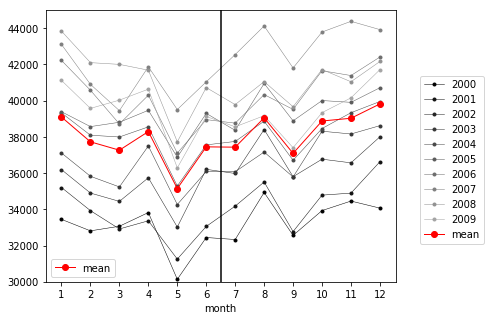

In [14]:
# Plotting years

fig, ax = plt.subplots()


x=0
while x<10 :
    y=x/14
    dfb.loc[dfb['year']==2000+x].plot(x='month',y='n',linestyle='-',linewidth=0.5, marker='.',ylim=(30000,45000), \
                                      ax=ax, label=2000+x, legend=None, color=str(y), figsize=(7,5))
    x+=1

df_mean.plot(x='month',y='mean',linestyle='-',linewidth=1, marker='o', color="r", ax=ax)
fig.legend(loc=7)
plt.axvline(x=6.5, color="black")
fig.subplots_adjust(right=0.82)
plt.xticks(np.arange(1,13, step=1))
plt.yticks(np.arange(30000,45000, step=2000))
plt.show()

#### move to Placebo Test !
#### 2007 series in blue!

Clearly, there is a seasonal pattern, e.g. a drop in May and Spetember as well as a peak in August. Note, that this seasonal pattern in the number of conceptions also partly reflects differences in the number of days per month.

Include also years 2007 and 2008-2010? Or Print 2007 in different color? Also, be aware, how mean is calculated...

In [15]:
dfb.head()

,mc,n,month,july,days,post,mc2,mc3,ln,jan,...,apr,mai,jun,jul,aug,sep,oct,nov,dec,year
0,-100.0,6,3,0,31,0,10000.0,-1000000.0,1.791759,0,...,0,0,0,0,0,0,0,0,0,1999.0
1,-99.0,24690,4,0,30,0,9801.0,-970299.0,10.114154,0,...,1,0,0,0,0,0,0,0,0,1999.0
2,-98.0,30595,5,0,31,0,9604.0,-941192.0,10.328592,0,...,0,1,0,0,0,0,0,0,0,1999.0
3,-97.0,32547,6,0,30,0,9409.0,-912673.0,10.390440,0,...,0,0,1,0,0,0,0,0,0,1999.0
4,-96.0,32352,7,1,31,0,9216.0,-884736.0,10.384431,0,...,0,0,0,1,0,0,0,0,0,1999.0


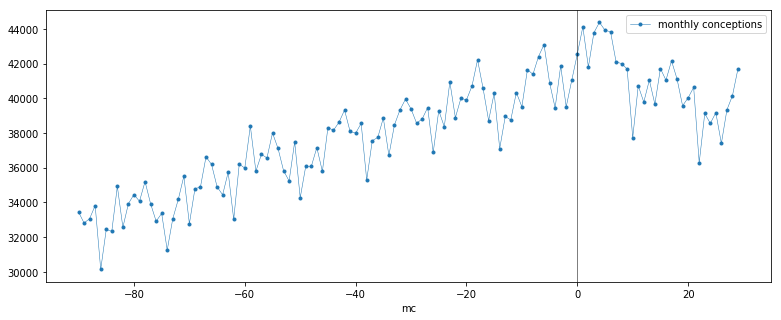

In [16]:
dfb.loc[(dfb['year']>=2000)&(dfb['year']<=2009)].plot(x='mc',y='n',linestyle='-',linewidth=0.5, marker='.',\
                                                      figsize=(13,5), label="monthly conceptions")
plt.axvline(x=0, color="black", linewidth=0.5)

#### Antonia zur freien Verfügung!

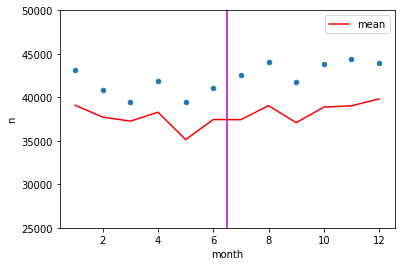

In [17]:
# Plotting 2007 vs. mean 

ax1=dfb.loc[dfb['year']==2007,['month','n']].plot(x='month',y='n',kind="scatter",ylim=(25000,50000))
df_mean.plot(x='month',y='mean',kind="line", color="r", ax=ax1)
plt.axvline(x=6.5, color="m")
plt.show()

#### wahrscheinlich weglassen

#### Abortions:

Now, processing the second data set containing information about abortions.

First, the raw data:

In [18]:
pd.read_stata('data/data_abortions_20110196.dta').describe().round(2)

,year,month,n_ive_and,n_ive_val,n_ive_rioja,n_ive_cat,n_ive_can,n_ive_mad,n_ive_gal,n_ive_bal,n_ive_pv,n_ive_castlm,n_ive_ast,n_ive_arag
count,144.00,144.00,132.00,132.00,120.00,120.00,144.00,120.00,120.00,120.00,120.00,132.00,132.00,132.00
mean,2004.50,6.50,1304.08,769.14,40.45,1520.87,303.17,1415.85,215.08,212.16,190.10,251.08,177.80,286.87
std,3.46,3.46,350.94,173.65,9.08,372.71,84.05,326.50,29.13,33.21,48.82,23.85,25.58,44.14
min,1999.00,1.00,694.00,430.00,21.00,957.00,161.00,820.00,159.00,146.00,105.00,198.00,117.00,175.00
25%,2001.75,3.75,1006.50,634.75,34.00,1207.50,236.00,1192.00,196.00,189.00,147.00,234.75,158.00,265.75
50%,2004.50,6.50,1313.50,772.00,40.00,1411.00,269.50,1383.00,211.50,211.00,184.50,252.00,178.00,287.00
75%,2007.25,9.25,1580.50,898.25,46.25,1801.00,374.25,1647.50,228.00,235.25,236.25,264.25,196.00,317.00
max,2010.00,12.00,2021.00,1144.00,67.00,2442.00,483.00,2113.00,341.00,295.00,283.00,315.00,241.00,398.00


The variables starting with "n_ive_" are the number of abortions per month in different regions of Spain. For some regions we have observations for 1999-2009 and for others from 2000-2010.

The manipulations are comparable to those for the births data set and can be found in the auxiliary-file.

The following is part of the paper's Table 1 - Descriptive Statitics

In [19]:
dfa = process_abortions_data()
print('Table 2 - Descriptive Statistics - Abortions')
print(dfa[['n_tot','post','m']].describe().round(2))

Table 2 - Descriptive Statistics - Abortions
         n_tot    post       m
count   120.00  120.00  120.00
mean   6724.62    0.25  -30.50
std    1348.07    0.43   34.79
min    4512.00    0.00  -90.00
25%    5624.00    0.00  -60.25
50%    6535.50    0.00  -30.50
75%    7710.75    0.25   -0.75
max    9553.00    1.00   29.00


The specifications, the author uses, differ with respect to the number of months included in the dataset and with respect to the order of the month-polynomial.

The following tabale corresponds to Table 2 - Fertility Results (Conceptions and Abortions) (p. 170)
<a id='table_fertility'></a>

In [20]:
reg_list_b = reg_conception(dfb)
reg_list_a = reg_abortion(dfa)
table_reg_output(reg_list_b, reg_list_a)

Table 3 - Fertility Results (Conceptions and Abortions)
————————————————————————————————————————————————————————————————————————————————————————————————————————————————————
               RDD (1)      RDD (2)      RDD (3)      RDD (4)      RDD (5)      MFE (6)      MFE (7)      MFE (8)   
              10 years      5 years    12 months     9 months     3 months     10 years      7 years      5 years   
————————————————————————————————————————————————————————————————————————————————————————————————————————————————————
Conceptions     0.0531**     0.0695***    0.0852**     0.0750***    0.0503       0.0495***    0.0539***    0.0527***                                                                                                                    
                0.0219       0.0250       0.0359       0.0285       0.0314       0.0103       0.0088       0.0136                                                                                                                       
          

For conceptions: We can observe small differences with respect to the 7 and 10 years specifications because because we take into account all leap years during those time periods while the author took only 2008 into account.

For abortions: LG accounted for all three leap years as well and, therefore, our results are identical to those in the paper.

#### Visualization of Regression Results
The following two plots show the data and the fitted regression line from the specification RDD(2). The range of mc is chosen according to Figure 1. Fertility Effect: Conceptions and Abortions by Month on page 171 of the article.

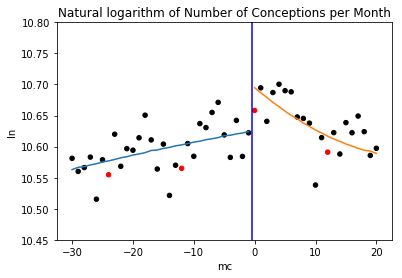

In [21]:
RDD_plot_conceptions(dfb, reg_list_b[1])

Visually, there might be an increase shortly after the inroduction of the policy. Especially if we compare the july-observations (shown in red). On the other hand, it could as well look like a continuation of the increasing time trend.

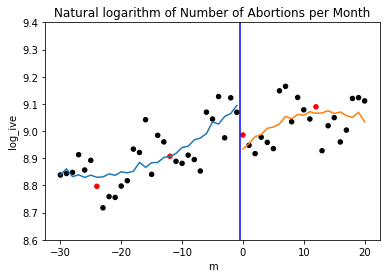

In [22]:
RDD_plot_abortions(dfa, reg_list_a[1])

#### Figures to compare with Figure 1. Fertility Effect (p. 171)

<img src="causal-graphs/Figure 1. Fertility Effect.png" width="400" />

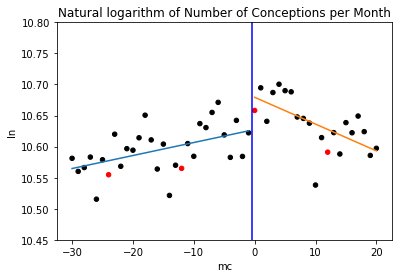

In [23]:
b_reg_for_plot = smf.ols(formula =
            'ln ~ post + mc + post*mc', data=dfb.loc[(dfb['mc']>-31) & (dfb['mc']<21)]).fit(cov_type='HC1')
RDD_plot_conceptions(dfb, b_reg_for_plot)

An important difference is that the plot in the paper uses bimonthly data, meaning that two months are summed up for the plot. Therefore, the jump at the cutoff looks much huger than it actually is.

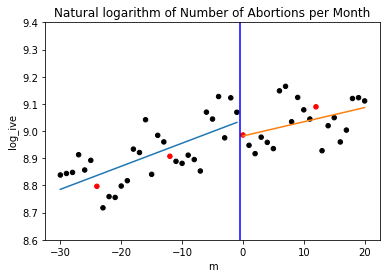

In [24]:
a_reg_for_plot = smf.ols(formula =
            'log_ive ~ post + m + post*m', data=dfa.loc[(dfa['m']>-31) & (dfa['m']<21)]).fit(cov_type='HC1')
RDD_plot_abortions(dfa, a_reg_for_plot)

<a id='hbs_lfs'></a>
### 3.2) Household Expenditure and Labor Supply

*Household Expenditure and Use of Daycare*

For analyzing the effect on household expenditure and the use of day care, the author exploits the so-called "Household Budget Survey" (HBS), a cross-sectional data set provieded by the Spanish National Statistics Institute. In particular, González considers only households that were interviewed in 2008 and had a baby between October 2006 and March 2008 (both included), which leaves her with 958 observations. A description of the utilized variables and their corresponding descriptive statistics can be found below. 

In [25]:
df_hbs = read_and_manipulate_hbs()

In [26]:
print('\x1b[1m' 'Table 3: Descriptive Statistics - Household Budget Survey (2008)')
df_hbs.loc[(df_hbs['month']>-10) & (df_hbs['month']<9), ['gastmon', 'c_m_exp', 'dur_exp', \
            'm_exp12312', 'post', 'month', 'agemom', 'sec1mom', 'sec2mom', 'unimom','immig', \
            'sib']].describe().loc[['mean','std','min','50%']].round(3)

Table 3: Descriptive Statistics - Household Budget Survey (2008)


,gastmon,c_m_exp,dur_exp,m_exp12312,post,month,agemom,sec1mom,sec2mom,unimom,immig,sib
mean,30507.152,4778.250,5654.333,305.794,0.487,-0.780,32.521,0.234,0.326,0.320,0.165,0.539
std,17721.420,4274.954,8740.152,848.094,0.500,5.056,5.448,0.423,0.469,0.467,0.371,0.499
min,3784.887,0.000,0.000,0.000,0.000,-9.000,0.000,0.000,0.000,0.000,0.000,0.000
50%,26144.552,3561.401,2276.193,0.000,0.000,-1.000,33.000,0.000,0.000,0.000,0.000,1.000


In [27]:
df_hbs = preparation_hbs()
# note: zero observations are explicitly excluded in the code line when computing the ln(), still python returns a notification

C:\Users\Antonia\Documents\student-project-antonia-marc\auxiliary\auxiliary_m.py:93: RuntimeWarning: divide by zero encountered in log
  df_hbs.loc[df_hbs['c_m_exp']!=0, 'lcexp'] = np.log(df_hbs.c_m_exp)
C:\Users\Antonia\Documents\student-project-antonia-marc\auxiliary\auxiliary_m.py:95: RuntimeWarning: divide by zero encountered in log
  df_hbs.loc[df_hbs['dur_exp']!=0, 'ldurexp'] = np.log(df_hbs.dur_exp)


The author then applies a range of different regression specifications to three different dependent variables: total household expenditure, child-related expenditure and durable goods expenditure. The same is repeated with the natural logarithm of them as dependent variables. The results are presented in the following table. 

In [28]:
# time windows:
spec1 = df_hbs.loc[(df_hbs['month']>-10) & (df_hbs['month']<9)]
spec2 = df_hbs.loc[(df_hbs['month']>-7) & (df_hbs['month']<6)]
spec3 = df_hbs.loc[(df_hbs['month']>-5) & (df_hbs['month']<4)]
spec4 = df_hbs.loc[(df_hbs['month']>-4) & (df_hbs['month']<3)]
spec5_6 = df_hbs.loc[(df_hbs['month']>-3) & (df_hbs['month']<2)]
spec7 = df_hbs

# creating lists:
dep_vars = ["gastmon", "ltotexp", "c_m_exp", "lcexp", "dur_exp", "ldurexp"]
dep_vars_name = ["Tot. exp.", "ln[Tot. exp.]", "Child-rel. exp.", "ln[Child-rel. exp.]",\
                  "Dur. goods exp.", "ln[Dur. goods exp.]"]

#regressions:
reg_spec1 = []
for dep_var in dep_vars:
    formula = dep_var + "~ post + month + month2 + nomom + agemom + age2 + age3 + sec1mom + sec2mom + unimom + immig + sib + post_month + post_month2 + mes_enc_2 + mes_enc_3 + mes_enc_4 + mes_enc_5 + mes_enc_6  + mes_enc_7 + mes_enc_8 + mes_enc_9 + mes_enc_10 + mes_enc_11 +  mes_enc_12"
    reg_spec1.append(smf.ols(formula=formula, data = spec1).fit(cov_type='HC1'))

reg_spec2 = []
for dep_var in dep_vars:
    formula = dep_var + "~ post + month + nomom + agemom + age2 + age3 + sec1mom + sec2mom + unimom + immig + sib + post_month + mes_enc_2 + mes_enc_3 + mes_enc_4 + mes_enc_5 + mes_enc_6  + mes_enc_7 + mes_enc_8 + mes_enc_9 + mes_enc_10 + mes_enc_11 +  mes_enc_12"
    reg_spec2.append(smf.ols(formula=formula, data = spec2).fit(cov_type='HC1'))

reg_spec3 = []
for dep_var in dep_vars:
    formula = dep_var + "~ post + month + nomom + agemom + age2 + age3 + sec1mom + sec2mom + unimom + immig + sib + post_month + mes_enc_2 + mes_enc_3 + mes_enc_4 + mes_enc_5 + mes_enc_6  + mes_enc_7 + mes_enc_8 + mes_enc_9 + mes_enc_10 + mes_enc_11 +  mes_enc_12"
    reg_spec3.append(smf.ols(formula=formula, data = spec3).fit(cov_type='HC1'))

reg_spec4 = []
for dep_var in dep_vars:
    formula = dep_var + "~ post + nomom + agemom + age2 + age3 + sec1mom + sec2mom + unimom + immig + sib  + mes_enc_2 + mes_enc_3 + mes_enc_4 + mes_enc_5 + mes_enc_6  + mes_enc_7 + mes_enc_8 + mes_enc_9 + mes_enc_10 + mes_enc_11 +  mes_enc_12"
    reg_spec4.append(smf.ols(formula=formula, data = spec4).fit(cov_type='HC1'))

reg_spec5 = []
for dep_var in dep_vars:
    formula = dep_var + "~ post"
    reg_spec5.append(smf.ols(formula=formula, data = spec5_6).fit(cov_type='HC1'))

reg_spec6 = []
for dep_var in dep_vars:
    formula = dep_var + "~ post + nomom + agemom + age2 + age3 + sec1mom + sec2mom + unimom + immig + sib  + mes_enc_2 + mes_enc_3 + mes_enc_4 + mes_enc_5 + mes_enc_6  + mes_enc_7 + mes_enc_8 + mes_enc_9 + mes_enc_10 + mes_enc_11 +  mes_enc_12"
    reg_spec6.append(smf.ols(formula=formula, data = spec5_6).fit(cov_type='HC1'))
    
reg_spec7 = []
for dep_var in dep_vars:
    formula = dep_var + "~ post + month + month2 + nomom + agemom + age2 + age3 + sec1mom + sec2mom + unimom + immig + sib + post_month + post_month2 + mes_enc_2 + mes_enc_3 + mes_enc_4 + mes_enc_5 + mes_enc_6  + mes_enc_7 + mes_enc_8 + mes_enc_9 + mes_enc_10 + mes_enc_11 +  mes_enc_12 + n_month_2 + n_month_3 + n_month_4 + n_month_5 + n_month_6 + n_month_7 + n_month_8 + n_month_9 + n_month_10 + n_month_11 + n_month_12"
    reg_spec7.append(smf.ols(formula=formula, data = spec7).fit(cov_type='HC1'))

In [29]:
table_expenditures(dep_vars,dep_vars_name,reg_spec1,reg_spec2,reg_spec3,reg_spec4,reg_spec5,reg_spec6,reg_spec7)

———————————————————————————————————————————————————————————————————————————————————————————————————————
                        RDD 9m      RDD 6m      RDD 4m      RDD 3m      RDD 2m      RDD 2m         MFE   
                           (1)         (2)         (3)         (4)         (5)         (6)         (7)   
———————————————————————————————————————————————————————————————————————————————————————————————————————
Tot. exp.             -3175.158   -2247.452     404.622    -579.998   -1774.182   -1084.494   -1306.658   
                       2838.302    2244.167    2885.447    1552.861    2032.318    1831.721    2193.823   

ln[Tot. exp.]            -0.142      -0.105      -0.034      -0.041      -0.072      -0.060      -0.049   
                          0.092       0.074       0.092       0.052       0.067       0.063       0.071   

Child-rel. exp.        -406.931    -599.337     357.109     -21.104    -150.272       9.929      94.298   
                        765.670     617.533

In the simplest version, specification 5, González merely compares the means of the two months before and after the introduction of the policy. The same is done in specification 6 but there control variables, such as educational attainment of mother and father, are included - as it is done in all other specifications. In specification 1, it is controlled for a polynomial time trend up to order two, while in specifications 2-3 a linear time trend is employed. Time is not included as regressor in specifications 4-6.

While specifications 1-6 are more or less based on regression equation [(6)](#eq6), specification 7 is grounded on regression equation 5. Here, the author estimates monthly fixed effects to account for seasonality effects. 

None of the dependent variables exhibits a significant effect in any of the specifications. Therefore, the author concludes that the policy did not affect household expenditure. Note, that we are able to replicate the same numbers for the estimated coefficients as presented in the article. However, we are not able to reproduce specification 8 from the article which is based on an extended HBS data set that has not been provided by the author and which is also not publicly accessible online from the Spanish  National Statistics Institute. 

Turning towards childcare, González employs the same specifications as described in the previous paragraph. In the following, we will present the results with respect to two dependent variables: expenditure on private daycare as well as a binary variable indicating whether private day care was used at all. In her article, González further considers the use of babysitters and official infant centers as dependent variables. However, the corresponding regressions were not listed in her do-file and unfortunately we were not able to identify the respective variables in the data set since variable labels are missing and we are not familiar with Spanish abbreviations. Note that according to the results presented in the article, the respective coefficient estimates were insignificant, anyway.

In [30]:
# creating lists:
dep_vars_childcare = ["m_exp12312", "daycare_bin"]
dep_vars_childcare_name = ["Private day care", "Priv. day care (binary)"]

#regressions:
reg_spec1_childcare = []
for dep_var in dep_vars_childcare:
    formula = dep_var + "~ post + month + month2 + nomom + agemom + age2 + age3 + sec1mom + sec2mom + unimom + immig + sib + post_month + post_month2 + mes_enc_2 + mes_enc_3 + mes_enc_4 + mes_enc_5 + mes_enc_6  + mes_enc_7 + mes_enc_8 + mes_enc_9 + mes_enc_10 + mes_enc_11 +  mes_enc_12"
    reg_spec1_childcare.append(smf.ols(formula=formula, data = spec1).fit(cov_type='HC1'))

reg_spec2_childcare = []
for dep_var in dep_vars_childcare:
    formula = dep_var + "~ post + month + nomom + agemom + age2 + age3 + sec1mom + sec2mom + unimom + immig + sib + post_month + mes_enc_2 + mes_enc_3 + mes_enc_4 + mes_enc_5 + mes_enc_6  + mes_enc_7 + mes_enc_8 + mes_enc_9 + mes_enc_10 + mes_enc_11 +  mes_enc_12"
    reg_spec2_childcare.append(smf.ols(formula=formula, data = spec2).fit(cov_type='HC1'))

reg_spec3_childcare = []
for dep_var in dep_vars_childcare:
    formula = dep_var + "~ post + month + nomom + agemom + age2 + age3 + sec1mom + sec2mom + unimom + immig + sib + post_month + mes_enc_2 + mes_enc_3 + mes_enc_4 + mes_enc_5 + mes_enc_6  + mes_enc_7 + mes_enc_8 + mes_enc_9 + mes_enc_10 + mes_enc_11 +  mes_enc_12"
    reg_spec3_childcare.append(smf.ols(formula=formula, data = spec3).fit(cov_type='HC1'))

reg_spec4_childcare = []
for dep_var in dep_vars_childcare:
    formula = dep_var + "~ post + nomom + agemom + age2 + age3 + sec1mom + sec2mom + unimom + immig + sib  + mes_enc_2 + mes_enc_3 + mes_enc_4 + mes_enc_5 + mes_enc_6  + mes_enc_7 + mes_enc_8 + mes_enc_9 + mes_enc_10 + mes_enc_11 +  mes_enc_12"
    reg_spec4_childcare.append(smf.ols(formula=formula, data = spec4).fit(cov_type='HC1'))

reg_spec5_childcare = []
for dep_var in dep_vars_childcare:
    formula = dep_var + "~ post"
    reg_spec5_childcare.append(smf.ols(formula=formula, data = spec5_6).fit(cov_type='HC1'))

reg_spec6_childcare = []
for dep_var in dep_vars_childcare:
    formula = dep_var + "~ post + nomom + agemom + age2 + age3 + sec1mom + sec2mom + unimom + immig + sib  + mes_enc_2 + mes_enc_3 + mes_enc_4 + mes_enc_5 + mes_enc_6  + mes_enc_7 + mes_enc_8 + mes_enc_9 + mes_enc_10 + mes_enc_11 +  mes_enc_12"
    reg_spec6_childcare.append(smf.ols(formula=formula, data = spec5_6).fit(cov_type='HC1'))
    

reg_spec7_childcare = []
for dep_var in dep_vars_childcare:
    formula = dep_var + "~ post + month + month2 + post_month + post_month2 + nomom + agemom + age2 + age3 + sec1mom + sec2mom + unimom + immig + sib  + mes_enc_2 + mes_enc_3 + mes_enc_4 + mes_enc_5 + mes_enc_6  + mes_enc_7 + mes_enc_8 + mes_enc_9 + mes_enc_10 + mes_enc_11 +  mes_enc_12 + n_month_2 + n_month_3 + n_month_4 + n_month_5 + n_month_6 + n_month_7 + n_month_8 + n_month_9 + n_month_10 + n_month_11 + n_month_12"
    reg_spec7_childcare.append(smf.ols(formula=formula, data = spec7).fit(cov_type='HC1'))
    
# regression with a global polynomial:
reg_spec7_childcare_global = []
for dep_var in dep_vars_childcare:
    formula = dep_var + "~ post + month + month2 + nomom + agemom + age2 + age3 + sec1mom + sec2mom + unimom + immig + sib  + mes_enc_2 + mes_enc_3 + mes_enc_4 + mes_enc_5 + mes_enc_6  + mes_enc_7 + mes_enc_8 + mes_enc_9 + mes_enc_10 + mes_enc_11 +  mes_enc_12 + n_month_2 + n_month_3 + n_month_4 + n_month_5 + n_month_6 + n_month_7 + n_month_8 + n_month_9 + n_month_10 + n_month_11 + n_month_12"
    reg_spec7_childcare_global.append(smf.ols(formula=formula, data = spec7).fit(cov_type='HC1'))
    


<a id='table_daycare'></a>

In [31]:
table_childcare(dep_vars_childcare,dep_vars_childcare_name,reg_spec1_childcare,reg_spec2_childcare,reg_spec3_childcare,reg_spec4_childcare,reg_spec5_childcare,reg_spec6_childcare,reg_spec7_childcare)

—————————————————————————————————————————————————————————————————————————————————————————————————————————————
                             RDD 9m      RDD 6m      RDD 4m      RDD 3m      RDD 2m      RDD 2m         MFE   
                                (1)         (2)         (3)         (4)         (5)         (6)        (7)*   
—————————————————————————————————————————————————————————————————————————————————————————————————————————————
Private day care            -137.915    -123.215    -195.384    -156.693*   -147.121    -158.186    -107.566   
                             169.540     121.075     160.720      80.009     101.274     103.271     125.126   

Priv. day care (binary)       -0.080      -0.099      -0.104      -0.094*     -0.110*     -0.125*      0.024   
                               0.094       0.074       0.094       0.054       0.062       0.064       0.072   

Linear trend in m               Yes         Yes         Yes          No          No          No         Yes


While the point estimates are for the most part negative, merely some of them turn out to be significant on the 10 percent level. Still, the author concludes in her article that 

Regarding specification 7, we present here the estimates based on a local polynomial time trend, i.e. the coefficients of the trend in $m$ are allowed to differ pre/post-treatment. Interestingly, the author at this point employs a global polynomial time trend - without mentioning this in the article. A comparison of the results of both approaches will be presented later on.

*Labor Supply*

In order to analyze the effect of the child benefit on maternal labor supply, González draws on another data set provided by the Spanish National Statistics Institute: the Labor Force Survey (LFS). Her sample consists of all households that had a child between October 2006 and March 2008 (both included) and that were interviewed in 2008. This results in 8,691 observations. A description of the relevant variables as well as table reporting descriptive statistics are presented below.

In [32]:
df_lfs = read_and_manipulate_lfs()

In [33]:
print('\x1b[1m' 'Table 4: Descriptive Statistics - Labor force survey (2008)')
df_lfs.loc[(df_lfs['m']>-10) & (df_lfs['m']<9), ['work', 'work2', 'post', 'm', 'age', \
       'primary', 'hsgrad', 'univ', 'immig', 'sib']].describe().loc[['mean','std','50%']].round(3)

Table 4: Descriptive Statistics - Labor force survey (2008)


,work,work2,post,m,age,primary,hsgrad,univ,immig,sib
mean,0.422,0.541,0.477,-0.815,32.376,0.236,0.343,0.297,0.170,0.523
std,0.494,0.498,0.499,5.128,5.252,0.425,0.475,0.457,0.376,0.500
50%,0.000,1.000,0.000,-1.000,33.000,0.000,0.000,0.000,0.000,1.000


In [34]:
df_lfs = preparation_lfs()

González then applies the same regression specifications as described above. As dependent variables she uses a variable indicating whether the mother worked in the week before the interview as well as a variable indicating whether the mother states that she is currently employed. The results are presented below. Note that the author estimates another specification based on an extended LFS data set which cannot be replicated because we do not have access to the data.

In [35]:
# time windows:
spec1 = df_lfs.loc[(df_lfs['m']>-10) & (df_lfs['m']<9)]
spec2 = df_lfs.loc[(df_lfs['m']>-7) & (df_lfs['m']<6)]
spec3 = df_lfs.loc[(df_lfs['m']>-5) & (df_lfs['m']<4)]
spec4 = df_lfs.loc[(df_lfs['m']>-4) & (df_lfs['m']<3)]
spec5_6 = df_lfs.loc[(df_lfs['m']>-3) & (df_lfs['m']<2)]
spec7 = df_lfs

#creating lists:
dep_vars_LS = ["work", "work2"]
dep_vars_LS_name = ["Working last week", "Employed"]


# regressions:
reg_spec1_LS = []
for dep_var in dep_vars_LS:
    formula = dep_var + "~ post + m + post_m + m2 + post_m2 + age + age2 + age3 + immig + primary + hsgrad + univ + sib + pleave + q_2 + q_3 + q_4"
    reg_spec1_LS.append(smf.ols(formula=formula, data = spec1).fit(cov_type='HC1'))

reg_spec2_LS = []
for dep_var in dep_vars_LS:
    formula = dep_var + "~ post + m + post_m +  age + age2 + age3 + immig + primary + hsgrad + univ + sib + pleave + q_2 + q_3 + q_4"
    reg_spec2_LS.append(smf.ols(formula=formula, data = spec2).fit(cov_type='HC1'))

reg_spec3_LS = []
for dep_var in dep_vars_LS:
    formula = dep_var + "~ post + m + post_m +  age + age2 + age3 + immig + primary + hsgrad + univ + sib + pleave + q_2 + q_3 + q_4"
    reg_spec3_LS.append(smf.ols(formula=formula, data = spec3).fit(cov_type='HC1'))

reg_spec4_LS = []
for dep_var in dep_vars_LS:
    formula = dep_var + "~ post + age + age2 + age3 + immig + primary + hsgrad + univ + sib + pleave + q_2 + q_3 + q_4"
    reg_spec4_LS.append(smf.ols(formula=formula, data = spec4).fit(cov_type='HC1'))

reg_spec5_LS = []
for dep_var in dep_vars_LS:
    formula = dep_var + "~ post "
    reg_spec5_LS.append(smf.ols(formula=formula, data = spec5_6).fit(cov_type='HC1'))

reg_spec6_LS = []
for dep_var in dep_vars_LS:
    formula = dep_var + "~ post + age + age2 + age3 + immig + primary + hsgrad + univ + sib + pleave + q_2 + q_3 + q_4"
    reg_spec6_LS.append(smf.ols(formula=formula, data = spec5_6).fit(cov_type='HC1'))

reg_spec7_LS = []
for dep_var in dep_vars_LS:
    formula = dep_var + "~ post + m + post_m + m2 + post_m2 + age + age2 + age3 + immig + primary + hsgrad + univ + sib + pleave + q_2 + q_3 + q_4 + n_month_2 + n_month_3 + n_month_4 + n_month_5 + n_month_6 + n_month_7 + n_month_8 + n_month_9 + n_month_10 + n_month_11 + n_month_12"
    reg_spec7_LS.append(smf.ols(formula=formula, data = spec7).fit(cov_type='cluster', cov_kwds={'groups': df_lfs['m']}))
     
reg_spec8_LS = []
for dep_var in dep_vars_LS:
    formula = dep_var + "~ post + m + m2 + age + age2 + age3 + immig + primary + hsgrad + univ + sib + pleave + q_2 + q_3 + q_4 + n_month_2 + n_month_3 + n_month_4 + n_month_5 + n_month_6 + n_month_7 + n_month_8 + n_month_9 + n_month_10 + n_month_11 + n_month_12"
    reg_spec8_LS.append(smf.ols(formula=formula, data = spec7).fit(cov_type='cluster', cov_kwds={'groups': df_lfs['m']}))


# regressions needed for comparison in the autocorrelation part:
reg_spec7_LS_robust = []
for dep_var in dep_vars_LS:
    formula = dep_var + "~ post + m + post_m + m2 + post_m2 + age + age2 + age3 + immig + primary + hsgrad + univ + sib + pleave + q_2 + q_3 + q_4 + n_month_2 + n_month_3 + n_month_4 + n_month_5 + n_month_6 + n_month_7 + n_month_8 + n_month_9 + n_month_10 + n_month_11 + n_month_12"
    reg_spec7_LS_robust.append(smf.ols(formula=formula, data = spec7).fit(cov_type='HC1'))
     
reg_spec7_LS_NW = []
for dep_var in dep_vars_LS:
    formula = dep_var + "~ post + m + post_m + m2 + post_m2 + age + age2 + age3 + immig + primary + hsgrad + univ + sib + pleave + q_2 + q_3 + q_4 + n_month_2 + n_month_3 + n_month_4 + n_month_5 + n_month_6 + n_month_7 + n_month_8 + n_month_9 + n_month_10 + n_month_11 + n_month_12"
    reg_spec7_LS_NW.append(smf.ols(formula=formula, data = spec7).fit(cov_type='HAC',cov_kwds={'maxlags':1}))

In [36]:
table_LS(dep_vars_LS, dep_vars_LS_name, reg_spec1_LS, reg_spec2_LS, reg_spec3_LS, reg_spec4_LS, reg_spec5_LS, reg_spec6_LS, reg_spec7_LS, reg_spec8_LS)

——————————————————————————————————————————————————————————————————————————————————————————————————————————————————
                       RDD 9m      RDD 6m      RDD 4m      RDD 3m      RDD 2m      RDD 2m        MFE*       MFE**   
                          (1)         (2)         (3)         (4)         (5)         (6)         (7)         (8)   
——————————————————————————————————————————————————————————————————————————————————————————————————————————————————
Working last week       -0.064**    -0.043*     -0.058*     -0.053***   -0.055**    -0.058***   -0.021      -0.044***
                         0.032       0.025       0.031       0.018       0.022       0.021       0.018       0.015   

Employed                -0.063**    -0.039      -0.080***   -0.053***   -0.061***   -0.061***    0.005      -0.020   
                         0.031       0.024       0.030       0.017       0.022       0.021       0.017       0.017   

Linear trend in m         Yes         Yes         Yes         

Unanimously, the point estimates of the RDD specifications are negative, some of the even signficantly negative on the 1 percent level. This suggests that receiving the child beneift induced a decrease in labor supply.

Turning towards the MFE specification, again, the author employs a global polynomial time trend instead of a local polynomial one which would have allowed the time trend to differ pre/post-treatment. Here, we report the specification using a local polynomial approach, a comparison of the results will be shown later on.

Also, for the only time in her whole analysis, González not only uses heteroscedasticity-robust standard errors but additionally clusteres the standard errors at the monthly level in the MFE specification. This will be investigated later on as well. 

<a id='critique'></a>
## 4.) Critical Assesment of the Author's Empirical Work

<a id='autocorr'></a>
### 4.1) Autocorrelation

As pointed out by Hausman and Rapson (2018), in a RDiT setting, the researcher has to be aware of the possibility to encounter serially correlated standard errors. Clearly, the number of conceptions as well as the number of abortions are both pure time series data and thus it stands to reason to examine whether the residuals obtained in the corresponding regressions exhibit autocorrelation. Since the author does not mention this issue in her article, we will conduct such an examination in the following.

Starting with conceptions, we plot the autocorrelation functions (ACF) belonging to the respective regressions (see again the [regression table](#table_fertility)).

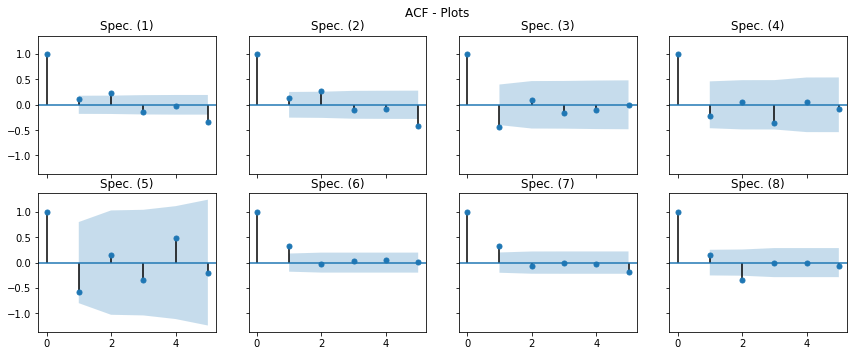

In [37]:
fig, axes = plt.subplots(ncols=4, nrows=2, sharex=True, sharey=True, figsize=(12,5))

plt.tight_layout()
fig.suptitle('ACF - Plots')
plt.subplots_adjust(top=0.9)

for x in range(4):
    smt.graphics.plot_acf(reg_list_b[x].resid,lags=5,alpha=0.05, ax=axes[0,x])
    axes[0,x].set_title('Spec. ('+str(x+1)+')')
    smt.graphics.plot_acf(reg_list_b[x+4].resid,lags=5,alpha=0.05, ax=axes[1,x])
    axes[1,x].set_title('Spec. ('+str(x+5)+')')

At least with respect to specifications 6 and 7, controlling for first-order autocorrelation is indicated. Therefore, we perform both regressions again and this time, we account for autocorrelation up to lag 1 using autocorrelation-and-heteroscedasticity-robust standard errors, as proposed by Newey and West (1987).

In [38]:
reg_list_b_NW = reg_conceptions_NW(dfb)
table_conceptions_NW(reg_list_b, reg_list_b_NW)

—————————————————————————————————————————————————
                       MFE (6)        MFE (7)   
                      10 years        7 years   
—————————————————————————————————————————————————
Conceptions -           0.0495***      0.0539***                                                 
  robust SE             0.0103         0.0088                                                    
                                                 
Conceptions -           0.0495***      0.0539***                                                 
  Newey West SE         0.0105         0.0085                                                    
—————————————————————————————————————————————————
Notes: The dependent variable is the natural logarithm of the monthly number of conceptions.
For each of the specifications, the coefficient of the binary treatment indicator is printed
in bold font. Standard errors are reported below.
***Significance at the 1 percent level.
 **Significance at the 5 percent l

Naturally, the point estimates stay the same But also the change in the standard errors is negligible. Still, we repeat the same exercise for abortions. The corresponding Autocorrelation Functions are plotted below.

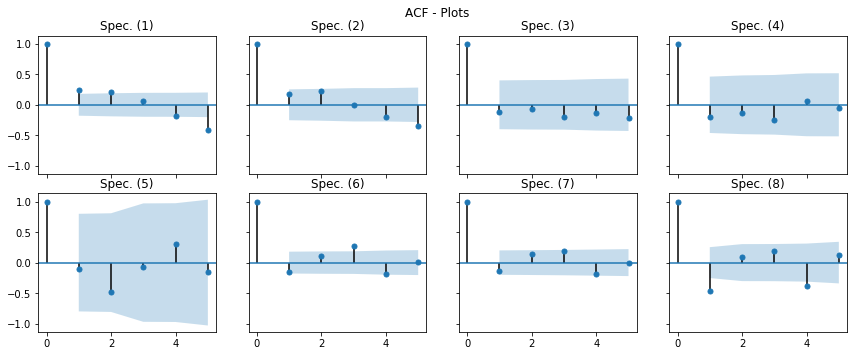

In [39]:
fig, axes = plt.subplots(ncols=4, nrows=2, sharex=True, sharey=True, figsize=(12,5))

plt.tight_layout()
fig.suptitle('ACF - Plots')
plt.subplots_adjust(top=0.9)

for x in range(4):
    smt.graphics.plot_acf(reg_list_a[x].resid,lags=5,alpha=0.05, ax=axes[0,x])
    axes[0,x].set_title('Spec. ('+str(x+1)+')')
    smt.graphics.plot_acf(reg_list_a[x+4].resid,lags=5,alpha=0.05, ax=axes[1,x])
    axes[1,x].set_title('Spec. ('+str(x+5)+')')

Only with respect to specification 8 we can clearly detect first-order autocorrelation - this time with a negative sign. This suggests that without accounting for serially correlation, the standard error tend to be overestimated. Therefore, we perform the regression again.

In [40]:
reg_list_a_NW = reg_abortions_NW(dfa)
table_abortions_NW(reg_list_a, reg_list_a_NW)

————————————————————————————————————————
                       MFE (8)   
                       5 years   
————————————————————————————————————————
Abortions -            -0.0649*                                                   
  robust SE             0.0366                                                    
                                                 
Abortions -            -0.0649***                                                 
  Newey West SE         0.0208                                                    
————————————————————————————————————————
Notes: The dependent variable is the natural logarithm of the monthly number of abortions.
The coefficient of the binary treatment indicator is printed in bold font. 
Standard errors are reported below.
***Significance at the 1 percent level.
 **Significance at the 5 percent level.
  *Significance at the 10 percent level.


As expected, the Newey West standard error is smaller than the one only accounting for heteroscedasticity. This time, the difference is even relevant for significance: the coefficient is now significant at the 1 percent level.

Lastly, we want to consider the one regression in which the author already adjusts standard errors: the MFE specification with labor supply variables as dependent variables. Again, we start with plotting the respective autocorrelation functions. Note that we base the regressions on a local polynomial time trend and not - as the author actually did - on a global polynomial trend.

Text(0.5, 1.0, 'Employed')

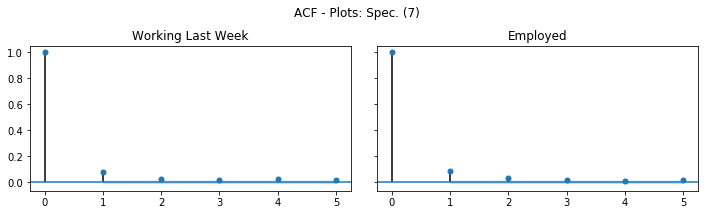

In [41]:
fig, axes = plt.subplots(ncols=2, nrows=1, sharex=True, sharey=True, figsize=(10,3))
plt.tight_layout()
fig.suptitle('ACF - Plots: Spec. (7)')
plt.subplots_adjust(top=0.8)
smt.graphics.plot_acf(reg_spec7_LS[0].resid,lags=5,alpha=0.05, ax=axes[0])
axes[0].set_title('Working Last Week')
smt.graphics.plot_acf(reg_spec7_LS[1].resid,lags=5,alpha=0.05, ax=axes[1])
axes[1].set_title('Employed')

Although the 5%-confidence bands are difficult to spot as they are very narrow around zero, accounting for first-order autocorrelation seems to be indicated. Thus, we compare the results for robust standard errors, clustered standard errors (as it is done by the author) and Newey-West standard errors in the following.

In [42]:
table_LS_ac(reg_spec7_LS_robust, reg_spec7_LS, reg_spec7_LS_NW)

————————————————————————————————————————
                                  MFE   
                                  (7)   
————————————————————————————————————————
Working last week -           -0.0213   
  robust SE                    0.0230   
  clustered SE                 0.0185   
  Newey-West SE                0.0232   
                                                 
Employed -                     0.0049   
  robust SE                    0.0226   
  clustered SE                 0.0175   
  Newey-West SE                0.0228   
————————————————————————————————————————
Notes: The coefficient of the binary treatment indicator is always printed in bold font. 
Standard errors are reported below.
***Significance at the 1 percent level.
 **Significance at the 5 percent level.
  *Significance at the 10 percent level.


The difference between heteroscedasticity-robust and Newey-West standard errors is again negligible. Clustered standard errors, however, are considerably smaller. Still, none of them would result in the coefficients being significant.

It remains the question why the author does not address the issue of autocorrelation in her article. One could speculate that she is aware of the problem since she employs clustering of the errors with respect to two dependent variables. However, it is unclear why she does not motivate or even mentions this in the paper. In particular, she could have explained why she only applies this method to those two dependent variables and not with regard to the other ones that have similar regression specifications and time windows.

More general, there does not appear to be an unquestionable way to deal with serial correlation in a RDiT setting. In a seminal paper in this strand of literature, Davis (2008) employs a RDiT design with respect to time series data on air pollution in Mexico City to infer the effect of a driving ban. He also uses clustered standard errors in his main specification but as alternative specification, he reports results with Newey-West standard errors. Clearly, it might be fruitful for further research to address the question how to appropriately deal with serial correlation in a RDiT framework.

<a id='mc_revised'></a>
### 4.2) Computing Month of Conception More Precisely

The author used the variables semanas to compute month of conception (mc). However, for some reason she did not extract the full information from this variable: If a woman stated that pregnancy lasted less than 39 weeks the author subtracted only 8 months from the variable month of birth. However, for a duration of less than 35 weeks the author did not subtract only 7 months but 8 months as well.

Because the variable month of conception is the running variable and, therefore, the most important explaining variable of the analysis, we want to compute it as precisely as possible and check whether our results will be different than the author's results. 

Note that since we addressed the issue of autocorrelation previously and concluded that it did not matter with respect to conceptions, here we only employ heteroscedasticity-robust standard errors. This also allows to directly compare the results with the ones presented by the author.

In [43]:
dfb_mc_new = mc_more_precisely()
reg_list_b_mc_new = reg_conception(dfb_mc_new)
table_reg_output_2(reg_list_b_mc_new, reg_list_b)

————————————————————————————————————————————————————————————————————————————————————————————————————————————————————
               RDD (1)      RDD (2)      RDD (3)      RDD (4)      RDD (5)      MFE (6)      MFE (7)      MFE (8)   
              10 years      5 years    12 months     9 months     3 months     10 years      7 years      5 years   
————————————————————————————————————————————————————————————————————————————————————————————————————————————————————
mc revised      0.0525**     0.0686***    0.0843**     0.0730**     0.0495       0.0501***    0.0544***    0.0540***                                                                                                                    
                0.0218       0.0252       0.0369       0.0290       0.0321       0.0104       0.0087       0.0136                                                                                                                       
                                                                  

The coefficient estimates using mc revised differ only slightly from our previous esimates. The significance levels at which one would reject the hypothesis that the policy had no effect on conceptions stay the same except for RDD (4). In RDD (4), with mc revised as dependent variable, the treatment dummy is significant at the 5 % level and not at the 1 % level anymore.

<a id='global_poly'></a>
### 4.3) Global vs. Local Polynomial Time Trend

In the following, we want to address the question whether deploying a global polynomial time trend changes the results compared to a specification with a local polynomial. Put differently: do the results differ when the interachtion term $(m \cdot D)$ in regression equation (7) is excluded - which would give a global polynomial time trend. 

As pointed out before, the author first utilizes a global polynomial time trend in the MFE regressions with respect to daycare. To keep the results comparable, we estimate both specification, global and local polynomial time trend, using only heteroscedasticity-robust standard errors.

In [44]:
table_daycare_poly(reg_spec7_childcare_global, reg_spec7_childcare)

————————————————————————————————————————
                                  MFE   
                                  (7)   
————————————————————————————————————————
Private day care            -107.5658   
- local polynomial           125.1260   
                                                 
Private day care            -176.6192** 
- global polynomial           83.5973   
                                                 
Priv. day care (binary)        0.0244   
- local polynomial             0.0718   
                                                 
Priv. day care (binary)       -0.0364   
- global polynomial            0.0500   
————————————————————————————————————————
Notes: The coefficient of the binary treatment indicator is always printed in bold font. 
Heteroscedasticity-robust standard errors are reported below.
***Significance at the 1 percent level.
 **Significance at the 5 percent level.
  *Significance at the 10 percent level.


The obtained differences are quite pronounced. With respect to "Private day care", employing a global polynomial time trend, as it is done by the author on this occasion, yield a significant effect on the 5 percent level and also the point estimate becomes more negative. With respect to the binary variable, both coefficients are insignificant but the point estimate is negative with a global polynomial time trend.

Undoubtedly, those results with a global polynomial time trend make a contribution such that the author was able conclude in her article that "families reciving the benefit  may have spent significantly less in private day care during the first year of the child's life" (González 2013: p. 180). This claim is mainly built upon the specification with a global polynomial as it is the only result being significant at the 5 percent level (see the [other results](#table_daycare) again).

We can only speculate why the author does not mention or motivate the use of a global polynomial in this particular case. Maybe she simply forgot to add it in her Stata code. Still, this is particularly troubling as the whole argument put forward by the author with respect to the use of daycare partly draws on the results with a global polynomial time trend.

Generally, it is not clear whether a local polynomial approach is more appropriate than a local one. While Davis (2008) deploys a local polynomial time trend, Gelman and Imbens (2019) recommend the use of a local polynomial function of lower order, i.e. linear or quadratic. However, the choice might also be context-dependent. That is why it is unfortunate that the author does not give reasons why she switches from local to global polynomials in certain cases.

<a id='further_analyses'></a>
## 5.) Further Analyses

<a id='abolishment'></a>
### 5.1) Abolishment of the Policy

In [45]:
df_births = create_births()

In [46]:
df_abolishment = preparation_abolishment(df_births)

In [47]:
# create necessary subsets of df_abolishment
df_abolishment_list = list()

df_abolishment_list.append(df_abolishment.loc[(df_abolishment['mc']>-31) & (df_abolishment['mc']<30)]) # 5 years
df_abolishment_list.append(df_abolishment.loc[(df_abolishment['mc']>-13) & (df_abolishment['mc']<12)]) # 12 months
df_abolishment_list.append(df_abolishment.loc[(df_abolishment['mc']>-10) & (df_abolishment['mc']<9)]) # 9 months
df_abolishment_list.append(df_abolishment.loc[(df_abolishment['mc']>-4) & (df_abolishment['mc']<3)]) # 3 months

# run regressions
reg1 = smf.ols(formula =
        'ln ~ post + mc + post*mc + mc2 + post*mc2 + days', data=df_abolishment_list[0]).fit(cov_type='HC1')
reg2 = smf.ols(formula =
        'ln ~ post + mc + post*mc + mc2 + post*mc2 + days', data=df_abolishment_list[1]).fit(cov_type='HC1')
reg3 = smf.ols(formula =
        'ln ~ post + mc + post*mc + days', data=df_abolishment_list[2]).fit(cov_type='HC1')
reg4 = smf.ols(formula =
        'ln ~ post + days', data=df_abolishment_list[3]).fit(cov_type='HC1')
reg5 = smf.ols(formula =
        'ln ~ post + mc + post*mc + mc2 + post*mc2 + days + feb + mar + apr + mai + jun + jul + aug + sep + oct + nov + dec', data=df_abolishment_list[0]).fit(cov_type='HC1')

# store regessions in list
reg_list_abolishment = [reg1, reg2, reg3, reg4, reg5]

In [48]:
table_abolishment(reg_list_abolishment)

———————————————————————————————————————————————————————————————————————————————————————
                 RDD (1)        RDD (2)        RDD (3)        RDD (4)        DID (5)   
                 5 years      12 months       9 months       3 months        5 years   
———————————————————————————————————————————————————————————————————————————————————————
Conceptions      -0.0961***     -0.1052**      -0.1266***     -0.0756**      -0.0397**                                                                                        
                  0.0263         0.0417         0.0388         0.0375         0.0166                                                                                          
———————————————————————————————————————————————————————————————————————————————————————
Notes: For each of the dependent variables, the coefficient of the binary treatment indicator variable is
printed in bold font. The corresponding standard errors are always reported below.
***Significance at th

## Placebo Tests

### Cutoff-Month: 07/2016

In [49]:
df_placebo_july = preparation_placebo_july(df_births)

In [50]:
# create necessary subsets of df_placebo_july
df_placebo_july_list = list()

df_placebo_july_list.append(df_placebo_july.loc[(df_placebo_july['mc']>-10) & (df_placebo_july['mc']<9)]) # 9 months
df_placebo_july_list.append(df_placebo_july.loc[(df_placebo_july['mc']>-4) & (df_placebo_july['mc']<3)]) # 3 months

reg1 = smf.ols(formula =
        'ln ~ post + mc + post*mc + days', data=df_placebo_july_list[0]).fit(cov_type='HC1')
reg2 = smf.ols(formula =
        'ln ~ post + days', data=df_placebo_july_list[1]).fit(cov_type='HC1')


# store regessions in list
reg_list_placebo_july = [reg1, reg2]

In [51]:
table_placebo_july(reg_list_placebo_july)

————————————————————————————————————————
                 RDD (1)        RDD (2)   
                9 months       3 months   
————————————————————————————————————————
Conceptions       0.0480         0.0085                                           
                  0.0339         0.0234                                           
————————————————————————————————————————
Notes: The dependent variable is the natural logarithm of the monthly number of conceptions.
For each of the specifications, the coefficient of the binary treatment indicator is printed
in bold font. The correpsonding standard errors are reported below.
***Significance at the 1 percent level.
 **Significance at the 5 percent level.
  *Significance at the 10 percent level.


Placebo test with respect to the cut-off month 07/2016 does not display a significant effect in the both feasible specifications. This supports the identification strategy.

### Cut-off Month: 05/2016

In [52]:
df_placebo_may = preparation_placebo_may(df_births)

In [53]:
# create necessary subsets of df_placebo_may
df_placebo_may_list = list()

df_placebo_may_list.append(df_placebo_may.loc[(df_placebo_may['mc']>-10) & (df_placebo_may['mc']<9)]) # 9 months
df_placebo_may_list.append(df_placebo_may.loc[(df_placebo_may['mc']>-4) & (df_placebo_may['mc']<3)]) # 3 months

#running regressions:
reg1 = smf.ols(formula =
        'ln ~ post + mc + post*mc + days', data=df_placebo_may_list[0]).fit(cov_type='HC1')
reg2 = smf.ols(formula =
        'ln ~ post + days', data=df_placebo_may_list[1]).fit(cov_type='HC1') 

# store regessions in list
reg_list_placebo_may = [reg1, reg2]

In [54]:
table_placebo_may(reg_list_placebo_may)

———————————————————————————————————————————
                 RDD (1)        RDD (2)   
                9 months       3 months   
———————————————————————————————————————————
Conceptions      -0.0987***     -0.0445***                                           
                  0.0373         0.0160                                              
———————————————————————————————————————————
Notes: The dependent variable is the natural logarithm of the monthly number of conceptions.
For each of the specifications, the coefficient of the binary treatment indicator is printed
in bold font. The correpsonding standard errors are reported below.
***Significance at the 1 percent level.
 **Significance at the 5 percent level.
  *Significance at the 10 percent level.


The placebo test with respect to the cut-off month 05/2016 suggests a significant decrease in conceptions. This is probably driven by seasonality and casts doubts on the general identification streategy using RDD. However, since applying a Diff-in-Diff is not feasible in this context, it remains unclear whether such an approach would be able to appropriately account for seasonality. In any case, the placebo test suggests a cautious interpretation of the above described findings regarding the abolishment of the policy.

## 5.3) Simulation Study

Hausman and Rapson (2018) study time-varying treatment and emphasize the difference between short-run and long-run effects. Considering the work by González, we thought about which effect policy makers would be interested in. González mentions that one explicit goal of governments offering a child benefit is to encourage fertility (p. 160). Therefore, they should be interested in whether the policy intervention increased the total number of births.

Thinking about whether this intervention might have a time-varying effect we conclude that people might only advance already planned births because they expect that the benefit won't be paid forever and they want to take the chance to get the cash payment. Thus, the policy might not trigger additional births but only change the timing of births. The counterfactual total number of births would then have been the same.

Additionally, it seems implausible to us, that the intervention causes a *jump* only one month after the introduction. It takes some time to make an important decision like becoming parents and, furthermore, most women need some time until they conceive. Gnoth et al (2003) find that only after 6 months about 90% of truly fertile couples conceive.

Thus, we are simulating a treatment effect which has two stages. The first stage has a positive effect on conceptions and lasts for about 6 months (the approximate time it takes until most women conceive) and the second stage has a negative effect and lasts for the next 6 months. These two stages simulate moving conceptions up in time. Furthermore, both stages have a "smooth phase-in" and a "smooth decay" (Hausman and Rapson, 2018, p.A-3) simulating that conceptions do not immediately work out. Note that with this treatment effect the total effect of the policy on the number of conceptions is 0. Simulating the treatment effect this way does not claim to be perfectly realisitic. However, it is a good approximation of moving conceptions up in time and allows us to use the sin-function for simulation.

As argued above, policy makers spending money on the intervention would then be interested in the overall effect which is 0 in our case. We will see that with this kind of treatment effect one should not use small bandwidths on both sides of the cut-off date in order to obtain the effect which is relevent for policy makers. Rather one should try to estimate the long-run effect of the policy.

Text(0.5, 1.0, 'No Policy Intervention')

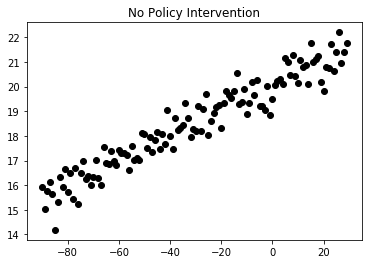

In [55]:
np.random.seed(234)
z = np.linspace(-90, 29, num = 120, dtype = int)
D = np.where(z < 0, 0, 1)
y_0 = 20 + 0.05*z + np.random.normal(0, 0.5, len(z))
plt.plot(z, y_0, 'o', color = 'k')
plt.title('No Policy Intervention')

The simulated data has the same number of observations like the real conceptions data. Furthermore, the data can be interpreted as monthly observations. However, the level of the simulated y can not be compared to the natural logarithm of the number of conceptions. Therefore, the value of any estimated coefficient should not be interpreted.

The following is the simulation of the time-varying treatment effect with it's two stages as described above.

Text(0.5, 1.0, 'Effect of Policy Intervention')

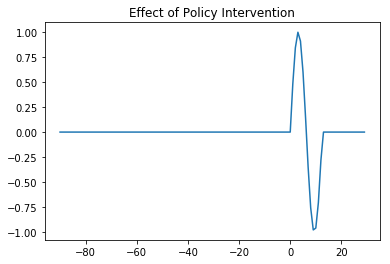

In [56]:
sin = np.zeros(len(z))
for i in z:
    sin[i] = math.sin(0.5*z[i])

T = np.where( (z < 0) | (z > 4*math.pi), 0, sin)
plt.plot(z, T)
plt.title('Effect of Policy Intervention')

Text(0.5, 1.0, 'With Policy Intervention')

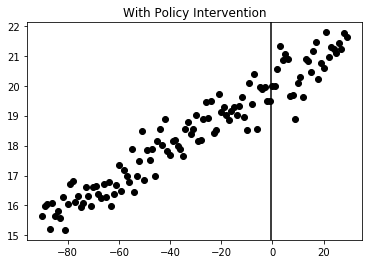

In [57]:
y = 20 + 0.05*z + T + np.random.normal(0, 0.5, len(z))
plt.plot(z, y, 'o', color = 'k')
plt.axvline(x = -0.5, color = 'k')
plt.title('With Policy Intervention')

After the cut-off one can see the shape of the sine-function.

Text(0.5, 1.0, 'Comparison - A Closer Look')

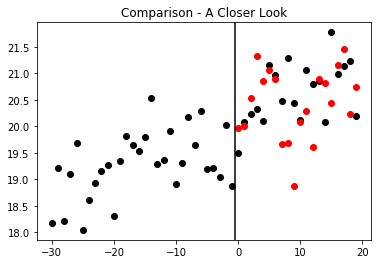

In [58]:
plt.plot(z[60:110], y_0[60:110], 'o', color = 'k')
plt.plot(z[90:110], y[90:110], 'o', color = 'r')
plt.axvline(x = -0.5, color = 'k')
plt.title('Comparison - A Closer Look')

For the simulation study we will estimate the regressions below. They resemble González regression analysis in the bandwidths chosen. However, while she used cubic, quadratic, and linear specifications we only use the a linear specification for the first four regressions, because our simulated data has a linear time trend and the real data seems to have a polynomial trend. For the last specification, González and we fit the depending variable only on a constant and the post-policy-dummy, D, since only 6 observations are used for the regression.

In [59]:
df = pd.DataFrame(data = {'y': y, 'z': z, 'D': D})

reg1 = smf.ols(formula = 'y ~ z + D + D*z', data = df).fit()
reg2 = smf.ols(formula = 'y ~ z + D + D*z', data = df.loc[(df['z']>-31) & (df['z']<30)]).fit()
reg3 = smf.ols(formula = 'y ~ z + D + D*z', data = df.loc[(df['z']>-13) & (df['z']<12)]).fit()
reg4 = smf.ols(formula = 'y ~ z + D + D*z', data = df.loc[(df['z']>-10) & (df['z']<9)]).fit()
reg5 = smf.ols(formula = 'y ~ D', data = df.loc[(df['z']>-4) & (df['z']<3)]).fit()

The fitted values look different depending on the size of the bandwidth.

Text(0.5, 1.0, 'Regression with large bandwidth')

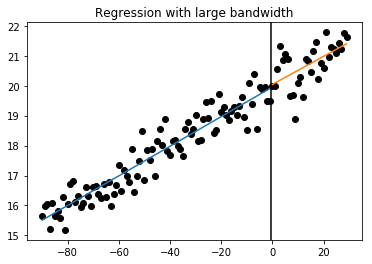

In [60]:
#plt.subplot(1, 2, 1)
plt.plot(z, y, 'o', color = 'k')
plt.plot(z[:90], reg1.fittedvalues[:90])
plt.plot(z[90:], reg1.fittedvalues[90:])
plt.axvline(x = -0.5, color = 'k')
plt.title('Regression with large bandwidth')

Text(0.5, 1.0, 'Regression with medium bandwidth')

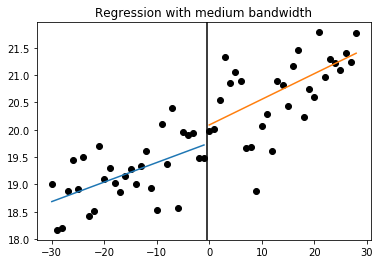

In [61]:
plt.plot(z[60:119], y[60:119], 'o', color = 'k')
plt.plot(z[60:90], reg2.fittedvalues[:30])
plt.plot(z[90:119], reg2.fittedvalues[31:])
plt.axvline(x = -0.5, color = 'k')
plt.title('Regression with medium bandwidth')

Text(0.5, 1.0, 'Regression with small bandwidth')

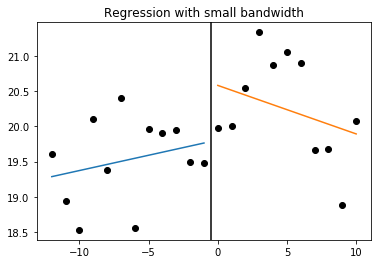

In [62]:
plt.plot(z[78:101], y[78:101], 'o', color = 'k')
plt.plot(z[78:90], reg3.fittedvalues[:12])
plt.plot(z[90:101], reg3.fittedvalues[13:])
plt.axvline(x = -0.5, color = 'k')
plt.title('Regression with small bandwidth')

From the plots above one can guess that the estimated coefficient of the post-policy-dummy, D, increases the smaller the bandwidth. Since this estimate would be interpreted as treatment effect in a standard RDD, its size is relevant.

The following function simulates N samples and runs the regressions for each.

In [63]:
np.random.seed(234)
N = 1000
params, bse, in_ci = simulating_results_from_different_bandwidths(z, D, T, N)

In [64]:
print_simulation_results(params, bse, in_ci, N)

Simulation Study - Results
————————————————————————————————————————————————————————————————————————————————————————————————————
                             RDD (1)       RDD (2)       RDD (3)       RDD (4)       RDD (5)
                            10 years       5 years     12 months      9 months      3 months
————————————————————————————————————————————————————————————————————————————————————————————————————
Estimated Coef. of D         0.1554        0.1613        0.9196        0.8198        0.5937                                                                                                                        
Standard Error               0.2895        0.3317        0.5234        0.5925        0.4664                                                                                                                        
0 in 0.95-Conf. Int.         0.9680        0.9690        0.6170        0.7430        0.7410                                                                      

As mentioned in the beginning, we see that if the policy intervention causes a moving up in time of conceptions and, thus, has an overall effect of 0 on conceptions, one should not use small bandwidths in order to obtain the effect which is relevent for policy makers. Rather one should use as many observations as possible and, thereby, try to estimate the long-run effect of the policy.

In case you wonder whether the true long run effect of the policy intervention is 0, you can increase the timespan available (beyond the timespan available for the article) and check that the mean of the estimated D-coefficient approaches zero.

In [65]:
np.random.seed(234)
params_ = increase_available_timespan(200)
params_.mean()

0.0006796841150375117

<a id='conclusion'></a>
## 6.) Conclusion

<a id='references'></a>
## References

Davis, L. W. (2008). The effect of driving restrictions on air quality in Mexico City. Journal of Political Economy, 116(1), 38-81.

Frölich, M., & Sperlich, S. (2019). Impact evaluation. Cambridge University Press.

Gelman, A., & Imbens, G. (2019). Why high-order polynomials should not be used in regression discontinuity designs. Journal of Business & Economic Statistics, 37(3), 447-456.

Gnoth, C., Godehardt, D., Godehardt, E., Frank‐Herrmann, P., & Freundl, G. (2003). Time to pregnancy: results of the German prospective study and impact on the management of infertility. Human reproduction, 18(9), 1959-1966.

González, L. (2013). The effect of a universal child benefit on conceptions, abortions, and early maternal labor supply. American Economic Journal: Economic Policy, 5(3), 160-88.

Hahn, J., Todd, P., & Van der Klaauw, W. (2001). Identification and estimation of treatment effects with a regression‐discontinuity design. Econometrica, 69(1), 201-209.

Hausman, C., & Rapson, D. S. (2018). Regression discontinuity in time: Considerations for empirical applications. Annual Review of Resource Economics, 10, 533-552.

Lee, D. S., & Lemieux, T. (2010). Regression discontinuity designs in economics. Journal of economic literature, 48(2), 281-355.

Morgan, S. L., & Winship, C. (2015). Counterfactuals and causal inference. Cambridge University Press.

Newey, W. K., & West, K. D. (1987). A Simple, Positive Semi-Definite, Heteroskedasticity and Autocorrelation Consistent Covariance Matrix. Econometrica: Journal of the Econometric Society, 703-708.

Pearl, J. (2000). Causality: models, reasoning and inference (Vol. 29). Cambridge: MIT press.

Rubin, D. B. (1974). Estimating causal effects of treatments in randomized and nonrandomized studies. Journal of educational Psychology, 66(5), 688.

Thistlethwaite, D. L., & Campbell, D. T. (1960). Regression-discontinuity analysis: An alternative to the ex post facto experiment. Journal of Educational psychology, 51(6), 309.


<a id='appendix'></a>
## Appendix